In [1]:
# natives
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from IPython.display import display, HTML
import warnings

# locals
from src.eventstudy import EventStudy
from datafeed import get_events_data, get_fx_data
from src.descriptives import describe_events, availability_map

warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-z948d5ns because the default path (/home/ipozdeev/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# data

## spot exchange rates
I collect FX spot rates of 25 'usual' currencies against the US dollar snapped at 15-minute intervals; this data is from Bloomberg (PX_LAST, BGN-compiled) and Thomson Reuters Eikon (Bid Close). Ten of these currencies and the US dollar itself comprise the 'g10' subsample. Within the whole sample, I calculate the average log-return across all currencies as a proxy for the US dollar index return.

Figure 1 below serves to give an impression of spot quotes availability. Currencies of certain emerging economies, such as Malaysia (MYR) or India (INR), feature a shorter history of data. All currencies lack quotes during weekends.

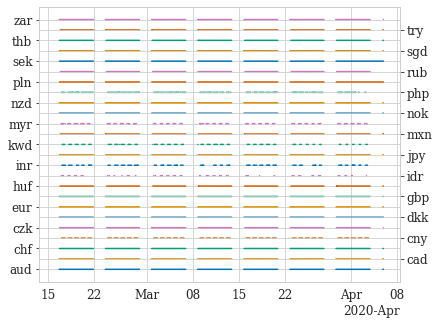

In [2]:
# raw data
data = get_fx_data()
r = np.log(data).diff()

display(HTML("<p><b>Figure 1.</b> Spot exchange rate availability.</p>"))
fig, ax = availability_map(r.loc["2020-02-15":"2020-04-05"])
fig.tight_layout()
fig.show()

Figure 2 depicts the dynamics of the dollar index over the same time period, when the US dollar appreciated by about 9% (in logarithmic terms) relative to the 25 currencies in my sample.

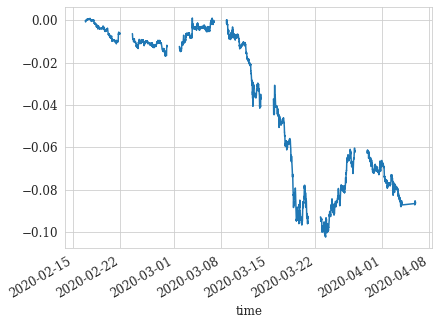

In [3]:
# get data
spot = get_fx_data()
r = np.log(spot).diff()
dol_idx = r.mean(axis=1)

# plot since 2020-02
display(HTML("<p><b>Figure 2.</b> Dollar index dynamics.</p>"))
fig, ax = plt.subplots()
dol_idx.loc["2020-02-15":"2020-04-05"].cumsum().plot(ax=ax)
fig.tight_layout()
fig.show()

## events
I collect timestamps of central banks' *surprize* rate cut announcements, otherwise referred to as 'events'. I take the earliest time the event is mentioned in the following sources: the official press release on the regulator's website, the official Twitter account of the regulator and the Bloomberg newsfeed. All timestamps are converted to CET (Europe/Zurich time) honoring the daylight saving time.

In **Table 1** below I show the timestamps and magnitudes of rate cut announcements from February 2020 to April 15th, 2020, indexed by the currency that the respective central bank issues. About half the central banks ventured for more than one rate cut, the maximum achieved by the Bank of Canada (three cuts). The US Federal Reserve initiated two cuts about two weeks apart.

Again, only surprize announcements are considered. Over the same timespan, the Central bank of Russia implemented a rate cut at a prescheduled meeting; this is taken out of the sample.

In [4]:
# raw data
events = get_events_data()

# add total count, rename columns, format dates, report in bps
evt_descr = describe_events(events)

# display
display(HTML("<p><b>Table 1.</b> Rate cut announcements.</p>"))
display(HTML(evt_descr))

time,aud,nok,cad,gbp,try,usd,mxn,brl,zar,inr,egp,idr
02/20 08:24,,,,,,,,,,,,-25
03/03 04:30,-50,,,,,,,,,,,
03/03 16:00,,,,,,-50,,,,,,
03/04 16:00,,,-50,,,,,,,,,
03/11 08:00,,,,-50,,,,,,,,
03/13 08:30,,-50,,,,,,,,,,
03/13 19:08,,,-50,,,,,,,,,
03/15 22:00,,,,,,-100,,,,,,
03/16 17:02,,,,,,,,,,,-300,
03/17 12:05,,,,,-100,,,,,,,


# methodology

I calculate 15-minute FX log-appreciation rates and the two US dollar index returns as mentioned in the previous section. 

I round the announcement time down to the previous quarter-hour and call it time 0. For example, if the cut was announced at 04:30, then the period from 04:15 to 04:30 becomes period -1, and the period  from 04:30 to 04:45 becomes period +1. I reindex the time series of 15-minute spot returns this way, such that each becomes centered on time 0.

In the event study on local announcements, I am interested in the average across individual centered series:
\begin{equation}
	\bar{y}_{\tau} = 1/N \sum \limits_{i} r_{i, \tau},
\end{equation}
where $r_{i, \tau}$ is return of currency $i=1,\ldots,N$ over $\tau$ periods after a cut by central bank $i$ (negative values of $\tau$ mean *before* cut).

In the event study on FOMC announcements, I am treating the US dollar index as one currency such that $N$ in the equation above becomes 1 and $i$ refers to the US dollar.

# results
## cuts by local central banks

Let us load the data, round the event times up to the nearest quarter-hour and center all individual spot appreciation rate series on these times (this is what `es.pivot()` below does). Let us then plot the within-currency averages of the appreciation rates as thin translucent lines, and the average across all currencies weighted by the amount of cuts a currency witnessed as the thick black line.

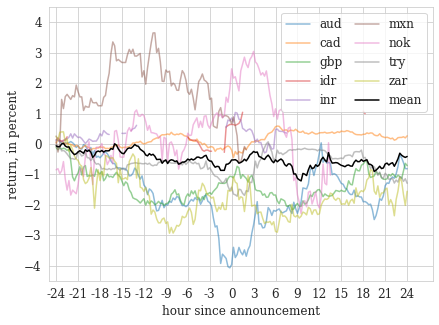

In [5]:
# data
spot = get_fx_data()
r = np.log(spot).diff() * 100
events = get_events_data()
events.index = events.index.ceil('15T')

# init event study with a window of (-96, 96) periods (24 hours)
es = EventStudy(data=r, events=events, window=(-96, 96),
                event_date_index=0)

# pivot, calculate average (event number-weighted)
pvt_i = es.pivot()
pvt_avg = es.event_weighted_mean(pvt_i)
to_plot_i = pvt_i.mean(axis=1, level=0).cumsum()
to_plot_avg = pvt_avg.cumsum()

# plot
fig, ax = plt.subplots()
to_plot_i.plot(ax=ax, alpha=0.5)
to_plot_avg.to_frame("mean").plot(ax=ax, color="k", linewidth=1.5)

# style plot
ax.set_xlim(-100, 110)
ax.set_ylim((-4.5, 4.5))
ax.set_xticks(np.arange(-96, 97, 12))
ax.set_xticklabels(np.arange(-96, 97, 12) // 4)
ax.set_xlabel("hour since announcement")
ax.set_ylabel("return, in percent")
ax.legend(ncol=2, columnspacing=1)

fig.tight_layout()
fig.show()

Although there are individual differences, the average response to a surprise rate cut is minuscule to the point of being indetectable.

## cuts by the fomc

Let us now repeat the exercise, but look at the cuts by the FOMC. To do so, we change variable `events` above to have the same two cuts for each currency in the sample.

In [6]:
# data
spot = get_fx_data()
r = np.log(spot).diff() * 100
events = get_events_data()

# round up the time events to the nearest 15 min
events.index = events.index.ceil('15T')

# retain FOMC events only
events_fomc = pd.concat([events["usd"].dropna(), ] * events.shape[1],
                        axis=1, keys=events.columns)

# take a look at the events now
display(HTML(events_fomc.to_html(na_rep='')))

currency,aud,nok,cad,gbp,try,usd,mxn,brl,zar,inr,egp,idr
time,,,,,,,,,,,,
2020-03-03 16:00:00+01:00,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0
2020-03-15 22:00:00+01:00,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


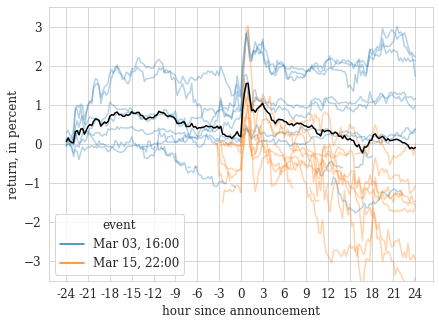

In [7]:
# init event study
es = EventStudy(data=r, 
                events=events_fomc, window=(-96, 96),
                event_date_index=0)

# pivot, compute the x-sectional mean
pvt_i = es.pivot()
pvt_avg = es.event_weighted_mean(pvt_i)

# plotted is the cumul sum thereof
# tells seaborn not to interpolate missing values
# to identify the column later
to_plot_avg = pvt_avg.cumsum()
to_plot_i = pvt_i.cumsum().stack(dropna=False).stack(dropna=False)\
    .replace(np.nan, np.inf)\
    .rename("r")\
    .reset_index()

# use seaborn
fig, ax = plt.subplots()

sns.lineplot(data=to_plot_i, x="d_periods", y="r",
             hue="evt_dt", units="currency", estimator=None,
             alpha=0.33, ax=ax)
to_plot_avg.plot(ax=ax, linewidth=1.5, color="k")

# style plot
ax.set_ylim((-3.5, 3.5))
ax.set_xticks(np.arange(-96, 97, 12))
ax.set_xticklabels(np.arange(-96, 97, 12) // 4)
ax.set_xlabel("hour since announcement")
ax.set_ylabel("return, in percent")
handles, labels = ax.get_legend_handles_labels()
labels = ["Mar 03, 16:00", "Mar 15, 22:00"]
ax.legend(handles, labels, loc="lower left", title="event")
fig.tight_layout()
fig.show()

There is limited availability of data before the event of March 15th, but whatever data is present points to a curious pattern: spot FX rates move around zero before the two events, then suddenly appreciate over 30 minutes after them, and take back some of the appreciation at the 1-hour mark, as if having overreacted. In the longer run after the events the dynamics is different between March 3rd and march 15th: in the latter case, depreciation is gaining pace as the economies slide further into recession and lockdowns are taking place.